In [1]:
import pymongo
from pymongo import MongoClient
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Bidirectional
import tensorflowjs as tfjs
import mediapipe as mp
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [3]:
client = MongoClient('18.119.73.10', 3002)
db = client.Dataset
db

Database(MongoClient(host=['18.119.73.10:3002'], document_class=dict, tz_aware=False, connect=True), 'Dataset')

In [4]:
poses = db.PoseValues

In [5]:
df = pd.DataFrame(list(poses.find()))

In [6]:
df.shape

(570, 3)

In [7]:
df = df[df['word'] != "dummy"]

In [8]:
df.shape

(520, 3)

In [9]:
df = df[df['word'] != "welcome"]

In [10]:
df.shape

(480, 3)

In [11]:
mp_drawing = mp.solutions.drawing_utils 
mp_holistic = mp.solutions.holistic

In [12]:
def plot_pose(data):
    row = 10
    column = 4
    fig, ax = plt.subplots(row,column, figsize=(20, 50), subplot_kw=dict(projection='3d'))
    pointer_row = 0
    pointer_col = 0
    for i in data:
        # fig[0,0].figure(figsize=(10, 10))
        # fig[0,0].axes(projection='3d')
        current = ax[pointer_row,pointer_col]
        # current = plt.figure(figsize=(10, 10))
        # print(pointer_row,pointer_col, row, column)
        if(pointer_col < column-1):
            pointer_col +=1
        else:
            pointer_col=0
            pointer_row += 1

        current.view_init(elev=10, azim=10)
        landmark_list = i['poseLandmarks'] #df.iloc[0].data[10]["poseLandmarks"]
        plotted_landmarks = {}
        if(landmark_list == None):
            continue
        for idx, landmark in enumerate(landmark_list):
            # print(landmark['x'])
            if(landmark['visibility'] < .5):
                continue
            current.scatter3D(
                    xs=[-landmark['z']],
                    ys=[landmark['x']],
                    zs=[-landmark['y']],
                    color=(1,0,0),
                    linewidth=2
                    )
            plotted_landmarks[idx] = (-landmark['z'], landmark['x'], -landmark['y'])
        connections= mp_holistic.POSE_CONNECTIONS
        if connections:
            num_landmarks = len(landmark_list)
            # Draws the connections if the start and end landmarks are both visible.
            for connection in connections:
                start_idx = connection[0]
                end_idx = connection[1]
                if not (0 <= start_idx < num_landmarks and 0 <= end_idx < num_landmarks):
                    raise ValueError(f'Landmark index is out of range. Invalid connection '
                                    f'from landmark #{start_idx} to landmark #{end_idx}.')
                if start_idx in plotted_landmarks and end_idx in plotted_landmarks:
                    landmark_pair = [
                        plotted_landmarks[start_idx], plotted_landmarks[end_idx]
                    ]
                    current.plot3D(
                        xs=[landmark_pair[0][0], landmark_pair[1][0]],
                        ys=[landmark_pair[0][1], landmark_pair[1][1]],
                        zs=[landmark_pair[0][2], landmark_pair[1][2]],
                        color=(0,0,1),
                        linewidth=2)

In [13]:
temp = df[df['word'] == "thank you"]

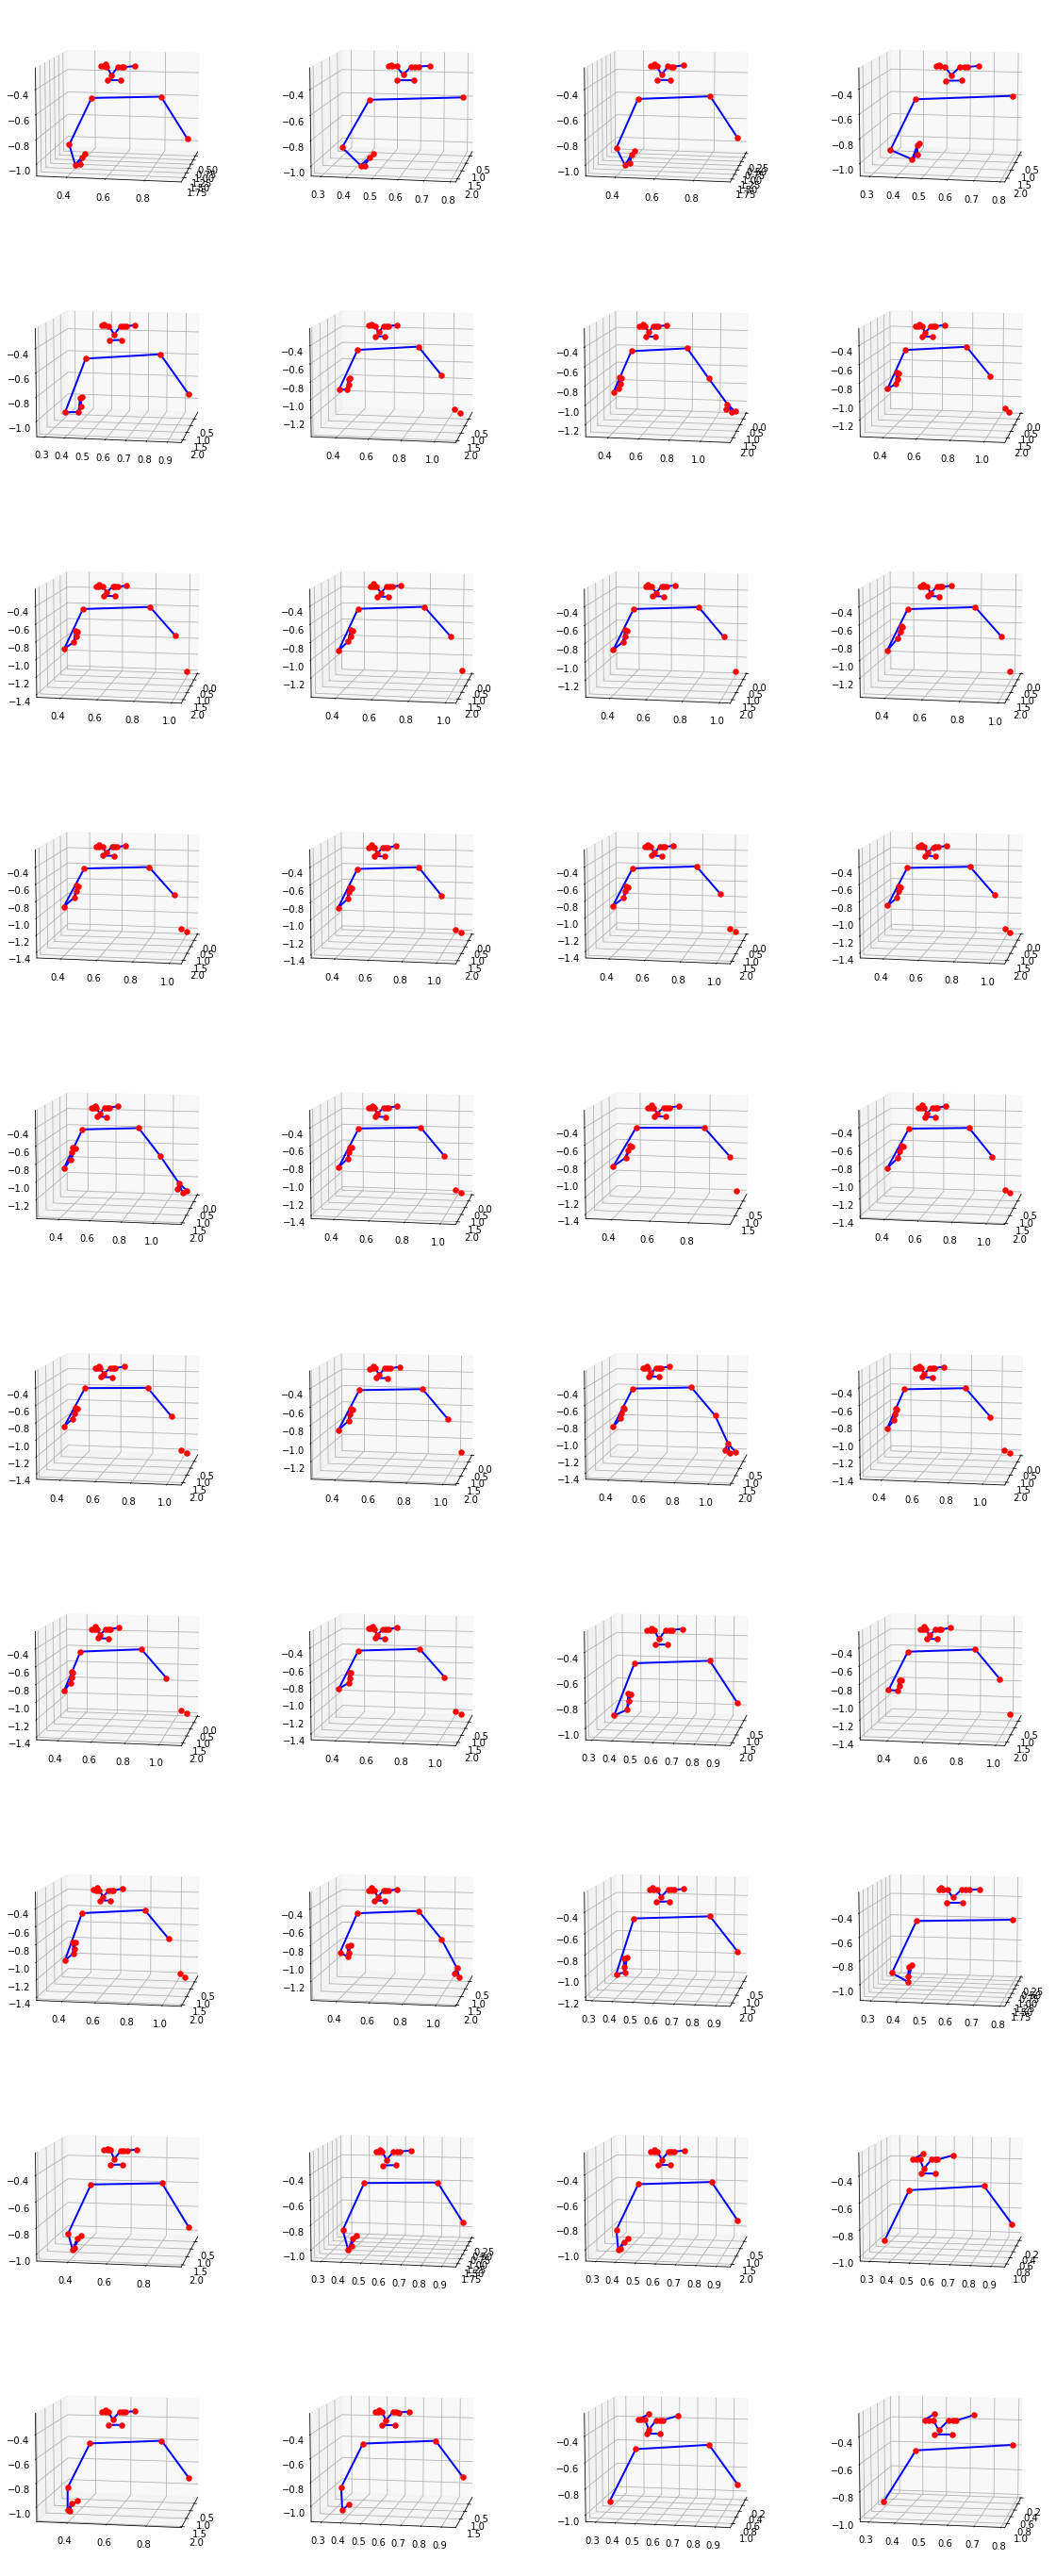

In [14]:
# fig, ax = plt.subplots(10,10)
plot_pose(temp.iloc[-25].data)


In [15]:
type(df['data'][0][0])

dict

In [16]:
def extract_keypoints(result):
    pose = np.array([[res['x'], res['y'], res['z'], res['visibility']] for res in result["poseLandmarks"]]).flatten() if "poseLandmarks" in result else np.zeros(33*4)
    lh = np.array([[res['x'], res['y'], res['z']] for res in result["leftHandLandmarks"]]).flatten() if "leftHandLandmarks" in result else np.zeros(21*3)
    rh = np.array([[res['x'], res['y'], res['z']] for res in result["rightHandLandmarks"]]).flatten() if "rightHandLandmarks" in result else np.zeros(21*3)
    face = np.array([[res['x'], res['y'], res['z']] for res in result["faceLandmarks"]]).flatten() if "faceLandmarks" in result else np.zeros(468*3)
    # ea = np.array([[res['x'], res['y'], res['z']] for res in result["ea"]]).flatten() if "ea" in result else np.zeros(33*3)
    return np.concatenate([pose, lh, rh, face])

In [17]:
extract_keypoints(df['data'][0][20]).shape

(1662,)

In [18]:
data = []
for videos in df['data']:
    frame_data = []
    for frames in videos:
        frame_data.append(extract_keypoints(frames))
    data.append(frame_data)

In [19]:
dataset = np.array(data)

In [20]:
dataset.shape

(480, 40, 1662)

In [21]:
words = np.array(df['word']).flatten()
words.shape

(480,)

In [22]:
label_map = {label:num for num, label in enumerate(np.unique(words))}
label_map

{'fine': 0,
 'help': 1,
 'hi': 2,
 'how': 3,
 'i': 4,
 'name': 5,
 'no': 6,
 'please': 7,
 'sorry': 8,
 'thank you': 9,
 'yes': 10,
 'you': 11}

In [23]:
label_map.keys()

dict_keys(['fine', 'help', 'hi', 'how', 'i', 'name', 'no', 'please', 'sorry', 'thank you', 'yes', 'you'])

In [24]:
labels = [label_map[word] for word in df['word']]

In [25]:
# with tf.device('/GPU'):
#     a = tf.random.normal(shape=(2,), dtype=tf.float32)
#     b = tf.nn.relu(a)

In [26]:
X = dataset
y = to_categorical(labels).astype(int)

In [27]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [42]:
# with tf.device('/CPU'):
# model = Sequential()
# model.add(Bidirectional(LSTM(64,dropout=0.2, recurrent_dropout=0.2, return_sequences=True, activation='relu', input_shape=(40, 1662))))
# model.add(Bidirectional(LSTM(128, return_sequences=True, activation='relu')))
# model.add(Bidirectional(LSTM(64, return_sequences=True, activation='relu')))
# model.add(Bidirectional(LSTM(128,dropout=0.2, recurrent_dropout=0.2, return_sequences=True, activation='relu')))
# # model.add(LSTM(64, return_sequences=True, activation='relu'))
# # model.add(LSTM(128, return_sequences=True, activation='relu'))
# model.add(Bidirectional(LSTM(64, return_sequences=False, activation='relu')))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(2, activation='softmax'))
# model.add(Dense(len(label_map.keys()), activation='softmax'))
# model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [44]:
model = Sequential()
# model.add(TimeDistributed(Conv2D(1, (2,2), activation='relu', padding='same', input_shape=(40,1662,1))))
# model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
# model.add(TimeDistributed(Flatten()))
model.add(LSTM(100, input_shape=(40, 1662)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
# model.add(LSTM(100,return_sequences=True, activation='relu', input_shape=(40, 1662)))
# model.add(LSTM(200, return_sequences=True, activation='relu'))
# model.add(LSTM(100, return_sequences=False, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
model.add(Dense(len(label_map.keys()), activation='softmax'))
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [37]:
X_test.shape


(24, 40, 1662)

In [38]:
y_test.shape

(24, 12)

In [45]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000
15/15 [==============================] - 2s 57ms/step - loss: 2.5531 - categorical_accuracy: 0.0592
Epoch 2/2000
15/15 [==============================] - 1s 60ms/step - loss: 2.4367 - categorical_accuracy: 0.1579
Epoch 3/2000
15/15 [==============================] - 1s 62ms/step - loss: 2.4347 - categorical_accuracy: 0.1338
Epoch 4/2000
15/15 [==============================] - 1s 64ms/step - loss: 2.3838 - categorical_accuracy: 0.1776
Epoch 5/2000
15/15 [==============================] - 1s 61ms/step - loss: 2.2582 - categorical_accuracy: 0.1776
Epoch 6/2000
15/15 [==============================] - 1s 60ms/step - loss: 2.1804 - categorical_accuracy: 0.2346
Epoch 7/2000
15/15 [==============================] - 1s 59ms/step - loss: 2.1123 - categorical_accuracy: 0.2171
Epoch 8/2000
15/15 [==============================] - 1s 60ms/step - loss: 2.0223 - categorical_accuracy: 0.2237
Epoch 9/2000
15/15 [==============================] - 1s 63ms/step - loss: 2.0269 - categorical_

KeyboardInterrupt: 

In [44]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               705200    
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 12)                1212      
                                                                 
Total params: 716,512
Trainable params: 716,512
Non-trainable params: 0
_________________________________________________________________


In [45]:
res = model.predict(X_test)
np.argmax(res[5])

2

In [46]:
y_test[5]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [47]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1/1 [==============================] - 0s 366ms/step - loss: 0.3157 - categorical_accuracy: 0.9583
Test set
  Loss: 0.316
  Accuracy: 0.958


In [48]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
multilabel_confusion_matrix(ytrue, yhat)

array([[[23,  0],
        [ 0,  1]],

       [[21,  0],
        [ 0,  3]],

       [[19,  0],
        [ 0,  5]],

       [[22,  0],
        [ 0,  2]],

       [[22,  0],
        [ 0,  2]],

       [[21,  0],
        [ 0,  3]],

       [[23,  0],
        [ 0,  1]],

       [[22,  1],
        [ 0,  1]],

       [[23,  0],
        [ 1,  0]],

       [[23,  0],
        [ 0,  1]],

       [[23,  0],
        [ 0,  1]],

       [[21,  0],
        [ 0,  3]]])

In [49]:
accuracy_score(ytrue, yhat)

0.9583333333333334

In [50]:
model.save('SLD.h5')

In [34]:
del model

In [52]:
loaded_model = load_model('SLD.h5')

In [53]:
loaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               705200    
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 12)                1212      
                                                                 
Total params: 716,512
Trainable params: 716,512
Non-trainable params: 0
_________________________________________________________________


In [54]:
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
# tflite_model = converter.convert()
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_new_converter=True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
tf.lite.OpsSet.SELECT_TF_OPS]

tfmodel = converter.convert()
open('image_model.tflite', 'wb').write(tfmodel)

2022-03-22 12:13:33.225429: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /var/folders/j5/v6fyg4pd095c4c97hw6gzbdr0000gn/T/tmpp4hbwe9f/assets


INFO:tensorflow:Assets written to: /var/folders/j5/v6fyg4pd095c4c97hw6gzbdr0000gn/T/tmpp4hbwe9f/assets
2022-03-22 12:13:49.113455: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-03-22 12:13:49.113469: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-03-22 12:13:49.114041: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/j5/v6fyg4pd095c4c97hw6gzbdr0000gn/T/tmpp4hbwe9f
2022-03-22 12:13:49.124602: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-03-22 12:13:49.124627: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /var/folders/j5/v6fyg4pd095c4c97hw6gzbdr0000gn/T/tmpp4hbwe9f
2022-03-22 12:13:49.175145: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-03-22 12:13:49.276910: I tensorflow/cc/saved_model/loader.cc:212] Running initialization

730000

In [55]:
tfjs.converters.save_keras_model(loaded_model, "./newjsModel")